# Customize Speaker Selection


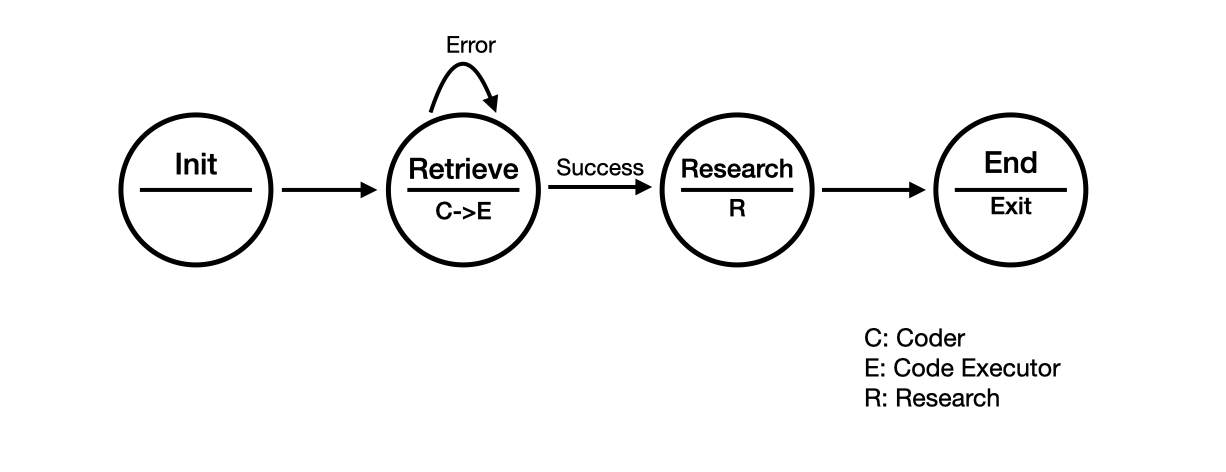

In GroupChat, we can customize the speaker selection by passing a function to the `GroupChat` object. With this function, you can build a more deterministic agent workflow. 

### Example research workflow

We first define the following agents:

i.   Initializer: Start the workflow by sending a task.

ii.  Coder: Retrieve papers from the internet by writing code.

iii. Executor: Execute the code.

iv.  Scientist: Read the papers and write a summary.

### Create your speaker selection function

In [ ]:
def custom_speaker_selection_func(
    last_speaker: Agent, 
    groupchat: GroupChat
) -> Union[Agent, Literal['auto', 'manual', 'random' 'round_robin'], None]:

    """Define a customized speaker selection function.
    A recommended way is to define a transition for each speaker in the groupchat.

    Parameters:
        - last_speaker: Agent
            The last speaker in the group chat.
        - groupchat: GroupChat
            The GroupChat object
    Return:
        Return one of the following:
        1. an `Agent` class, it must be one of the agents in the group chat.
        2. a string from ['auto', 'manual', 'random', 'round_robin'] to select a default method to use.
        3. None, which indicates the chat should be terminated.
    """
    pass

groupchat = autogen.GroupChat(
    speaker_selection_method=custom_speaker_selection_func,
    ...,
)

The last speaker and the groupchat object are passed to the function. Commonly used variables from groupchat are `groupchat.messages` and `groupchat.agents`, which is the message history and the agents in the group chat respectively. You can access other attributes of the groupchat, such as `groupchat.allowed_speaker_transitions_dict` for pre-defined `allowed_speaker_transitions_dict`.

In [ ]:
import os

import autogen

# Put your api key in the environment variable OPENAI_API_KEY
config_list = [
    {
        "model": "gpt-4-0125-preview",
        "api_key":"API_KEY_PLACEHOLDERproj-8jhaENcxBVVg8iAhSEQBT3BlbkFJ7S6mDafUVTonpaZWq7X1",
    }
]

# You can also create an file called "OAI_CONFIG_LIST" and store your config there
# config_list = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={
#         "model": ["gpt-4-0125-preview"],
#     },
# )

In [ ]:
gpt4_config = {
    "cache_seed": 42,  # change the cache_seed for different trials
    "temperature": 0,
    "config_list": config_list,
    "timeout": 120,
}

initializer = autogen.UserProxyAgent(
    name="Init",
)

coder = autogen.AssistantAgent(
    name="Retrieve_Action_1",
    llm_config=gpt4_config,
    system_message="""You are the Coder. Given a topic, write code to retrieve related papers from the arXiv API, print their title, authors, abstract, and link.
You write python/shell code to solve tasks. Wrap the code in a code block that specifies the script type. The user can't modify your code. So do not suggest incomplete code which requires others to modify. Don't use a code block if it's not intended to be executed by the executor.
Don't include multiple code blocks in one response. Do not ask others to copy and paste the result. Check the execution result returned by the executor.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
""",
)
executor = autogen.UserProxyAgent(
    name="Retrieve_Action_2",
    system_message="Executor. Execute the code written by the Coder and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "paper",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)
scientist = autogen.AssistantAgent(
    name="Research_Action_1",
    llm_config=gpt4_config,
    system_message="""You are the Scientist. Please categorize papers after seeing their abstracts printed and create a markdown table with Domain, Title, Authors, Summary and Link""",
)


def state_transition(last_speaker, groupchat):
    messages = groupchat.messages

    if last_speaker is initializer:
        # init -> retrieve
        return coder
    elif last_speaker is coder:
        # retrieve: action 1 -> action 2
        return executor
    elif last_speaker is executor:
        if messages[-1]["content"] == "exitcode: 1":
            # retrieve --(execution failed)--> retrieve
            return coder
        else:
            # retrieve --(execution success)--> research
            return scientist
    elif last_speaker == "Scientist":
        # research -> end
        return None


groupchat = autogen.GroupChat(
    agents=[initializer, coder, executor, scientist],
    messages=[],
    max_round=20,
    speaker_selection_method=state_transition,
)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt4_config)

In [ ]:
initializer.initiate_chat(
    manager, message="Topic: LLM applications papers from last week. Requirement: 5 - 10 papers from different domains."
)

# Resuming a Groupchat

using `resume` keyword : it returns the last agent in the messages as well as the last message itself. These can be used to run the *initiate_chat*

This prepares the GroupChat, GroupChatManager, and group chat’s agents for resuming. An agent’s *initiate_chat* can then be called to resume the chat.




In [ ]:
# Save chat messages for resuming later on using the chat history
messages_json = mygroupchatmanager.messages_to_string(previous_chat_result.chat_history)

# Alternatively you can use the GroupChat's messages property
messages_json = mygroupchatmanager.messages_to_string(mygroupchatmanager.groupchat.messages)

### Example

In [1]:
import os

import autogen

# Put your api key in the environment variable OPENAI_API_KEY
config_list = [
    {
        "model": "gpt-4-0125-preview",
        "api_key":"API_KEY_PLACEHOLDERproj-8jhaENcxBVVg8iAhSEQBT3BlbkFJ7S6mDafUVTonpaZWq7X1",
    }
]

gpt4_config = {
    "cache_seed": 42,  # change the cache_seed for different trials
    "temperature": 0,
    "config_list": config_list,
    "timeout": 120,
}

c:\Users\sides\.conda\envs\autogen\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
flaml.automl is not available. Please install flaml[automl] to enable AutoML functionalities.


In [2]:
# Create Agents, GroupChat, and GroupChatManager in line with the original group chat

planner = autogen.AssistantAgent(
    name="Planner",
    system_message="""Planner. Suggest a plan. Revise the plan based on feedback from admin and critic, until admin approval.
The plan may involve an engineer who can write code and a scientist who doesn't write code.
Explain the plan first. Be clear which step is performed by an engineer, and which step is performed by a scientist.
""",
    llm_config=gpt4_config,
)

user_proxy = autogen.UserProxyAgent(
    name="Admin",
    system_message="A human admin. Interact with the planner to discuss the plan. Plan execution needs to be approved by this admin.",
    code_execution_config=False,
)

engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=gpt4_config,
    system_message="""Engineer. You follow an approved plan. You write python/shell code to solve tasks. Wrap the code in a code block that specifies the script type. The user can't modify your code. So do not suggest incomplete code which requires others to modify. Don't use a code block if it's not intended to be executed by the executor.
Don't include multiple code blocks in one response. Do not ask others to copy and paste the result. Check the execution result returned by the executor.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
""",
)
scientist = autogen.AssistantAgent(
    name="Scientist",
    llm_config=gpt4_config,
    system_message="""Scientist. You follow an approved plan. You are able to categorize papers after seeing their abstracts printed. You don't write code.""",
)

executor = autogen.UserProxyAgent(
    name="Executor",
    system_message="Executor. Execute the code written by the engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "paper",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, scientist, planner, executor],
    messages=[],
    max_round=10,
)

manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt4_config)

In [3]:
# Messages in a JSON string
previous_state = r"""[{"content": "Find the latest paper about gpt-4 on arxiv and find its potential applications in software.", "role": "user", "name": "Admin"}, {"content": "Plan:\n1. **Engineer**: Search for the latest paper on GPT-4 on arXiv.\n2. **Scientist**: Read the paper and summarize the key findings and potential applications of GPT-4.\n3. **Engineer**: Identify potential software applications where GPT-4 can be utilized based on the scientist's summary.\n4. **Scientist**: Provide insights on the feasibility and impact of implementing GPT-4 in the identified software applications.\n5. **Engineer**: Develop a prototype or proof of concept to demonstrate how GPT-4 can be integrated into the selected software application.\n6. **Scientist**: Evaluate the prototype, provide feedback, and suggest any improvements or modifications.\n7. **Engineer**: Make necessary revisions based on the scientist's feedback and finalize the integration of GPT-4 into the software application.\n8. **Admin**: Review the final software application with GPT-4 integration and approve for further development or implementation.\n\nFeedback from admin and critic is needed for further refinement of the plan.", "role": "user", "name": "Planner"}, {"content": "Agree", "role": "user", "name": "Admin"}, {"content": "Great! Let's proceed with the plan outlined earlier. I will start by searching for the latest paper on GPT-4 on arXiv. Once I find the paper, the scientist will summarize the key findings and potential applications of GPT-4. We will then proceed with the rest of the steps as outlined. I will keep you updated on our progress.", "role": "user", "name": "Planner"}]"""

In [4]:
# Prepare the group chat for resuming
last_agent, last_message = manager.resume(messages=previous_state)

# Resume the chat using the last agent and message
result = last_agent.initiate_chat(recipient=manager, message=last_message, clear_history=False)

Prepared group chat with 4 messages, the last speaker is Planner
Planner (to chat_manager):

Great! Let's proceed with the plan outlined earlier. I will start by searching for the latest paper on GPT-4 on arXiv. Once I find the paper, the scientist will summarize the key findings and potential applications of GPT-4. We will then proceed with the rest of the steps as outlined. I will keep you updated on our progress.

--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

```python
import requests
from bs4 import BeautifulSoup

# Define the URL for the arXiv search
search_url = "https://arxiv.org/search/?query=GPT-4&searchtype=all&source=header"

# Perform the search request
response = requests.get(search_url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the first paper related to 

In [5]:
# Output the final chat history showing the original 4 messages and resumed messages
for i, message in enumerate(groupchat.messages):
    print(
        f"#{i + 1}, {message['name']}: {message['content'][:80]}".replace("\n", " "),
        f"{'...' if len(message['content']) > 80 else ''}".replace("\n", " "),
    )

#1, Admin: Find the latest paper about gpt-4 on arxiv and find its potential applications i ...
#2, Planner: Plan: 1. **Engineer**: Search for the latest paper on GPT-4 on arXiv. 2. **Scien ...
#3, Admin: Agree 
#4, Planner: Great! Let's proceed with the plan outlined earlier. I will start by searching f ...
#5, Engineer: ```python import requests from bs4 import BeautifulSoup  # Define the URL for th ...
#6, Executor: exitcode: 0 (execution succeeded) Code output:  Title: BiMediX2: Bio-Medical EXp ...
#7, Scientist: Based on the abstract of the paper titled "BiMediX2: Bio-Medical EXpert LMM for  ...
#8, Engineer: Given the insights provided by the scientist on the potential applications of GP ...
#9, Scientist: Given the current limitations, I'm unable to directly execute tasks such as deve ...
#10, Admin:  
#11, Admin:  


### Example of resuming a terminated Groupchat 

In [6]:
# Previous state with TERMINATE in the last message
previous_state = r"""[{"content": "Let's get this meeting started. We'll have a set order of speakers. First the Product_Manager will create 3 new product ideas. Then the Chief_Marketing_Officer will speak and talk about the idea they have chosen to move forward with. Then the Digital_Marketer will create 3 marketing strategies for that idea. We MUST stick to the speaking order which is Product_Manager first, Chief_Marketing_Officer second, Digital_Marketer third, and finally the Chief_Marketing_Officer will speak and end the meeting.", "role": "user", "name": "Chairperson"}, {"content": "Sounds like a plan! Let's get started.  As the Product_Manager, I'd like to present three new product ideas for our luxury car models:  1. 'EcoLux': A hybrid electric-gasoline vehicle that combines the best of both worlds, offering exceptional fuel efficiency and reduced carbon footprint. 2. 'AeroSport': A high-performance sports car with advanced aerodynamics, designed to deliver unparalleled speed and agility on the track or on the open road. 3. 'SmartDrive': An intelligent driver-assistance system that uses AI-powered sensors and cameras to anticipate and respond to potential hazards, ensuring a safer driving experience.  Now it's your turn, Chief_Marketing_Officer! Which of these ideas do you think has the most potential?", "role": "user", "name": "Chief_Marketing_Officer"}, {"content": "Thank you for presenting those innovative product ideas, Product_Manager.  After careful consideration, I believe 'EcoLux' has the most potential. With the growing concern about climate change and environmental sustainability, a hybrid electric-gasoline vehicle that offers exceptional fuel efficiency and reduced carbon footprint could be a game-changer in the luxury car market. Additionally, it aligns with our company's commitment to innovation and responsibility.  Now it's your turn, Digital_Marketer! Can you come up with three marketing strategies for 'EcoLux'?", "role": "user", "name": "Product_Manager"}, {"content": "Thank you, Chief_Marketing_Officer!  For 'EcoLux', I propose the following three marketing strategies:  1. 'Green Revolution' Campaign: Highlighting the eco-friendly features of EcoLux through a series of social media ads and influencer partnerships. We can partner with eco-conscious influencers to showcase how EcoLux is not only a luxury car but also an environmentally responsible choice. 2. 'Fuel for Thought' Content Series: Creating a content series that explores the intersection of technology, sustainability, and luxury. This could include blog posts, videos, and podcasts that delve into the innovative features of EcoLux and its impact on the environment. 3. 'EcoLux Experience' Event Marketing: Hosting exclusive events and test drives for potential customers to experience the performance and eco-friendliness of EcoLux firsthand. These events can be held at upscale locations and feature interactive exhibits, product demonstrations, and networking opportunities.  These strategies will help position EcoLux as a leader in the luxury electric-vehicle market while appealing to environmentally conscious consumers who value innovation and sustainability. TERMINATE", "role": "user", "name": "Digital_Marketer"}]"""

In [8]:
user_proxy = autogen.UserProxyAgent(
    name="Chairperson",
    system_message="The chairperson for the meeting.",
    code_execution_config={"use_docker": False},  # Disable Docker
    human_input_mode="TERMINATE",
)


cmo = autogen.AssistantAgent(
    name="Chief_Marketing_Officer",
    # system_message is used in the select speaker message
    description="The head of the marketing department working with the product manager and digital marketer to execute a strong marketing campaign for your car company.",
    # description is used to prompt the LLM as this agent
    system_message="You, Jane titled Chief_Marketing_Officer, or CMO, are the head of the marketing department and your objective is to guide your team to producing and marketing unique ideas for your luxury car models. Don't include your name at the start of your response or speak for any other team member, let them come up with their own ideas and strategies, speak just for yourself as the head of marketing. When yourself, the Product_Manager, and the Digital_Marketer have spoken and the meeting is finished, say TERMINATE to conclude the meeting.",
    is_termination_msg=lambda x: "TERMINATE" in x.get("content"),
    llm_config=gpt4_config,
)

pm = autogen.AssistantAgent(
    name="Product_Manager",
    # system_message is used in the select speaker message
    description="Product head for the luxury model cars product line in the car company. Always coming up with new product enhancements for the cars.",
    # description is used to prompt the LLM as this agent
    system_message="You, Alice titled Product_Manager, are always coming up with new product enhancements for the luxury car models you look after. Review the meeting so far and respond with the answer to your current task.  Don't include your name at the start of your response and don't speak for anyone else, leave the Chairperson to pick the next person to speak.",
    is_termination_msg=lambda x: "TERMINATE" in x.get("content"),
    llm_config=gpt4_config,
)

digital = autogen.AssistantAgent(
    name="Digital_Marketer",
    # system_message is used in the select speaker message
    description="A seasoned digital marketer who comes up with online marketing strategies that highlight the key features of the luxury car models.",
    # description is used to prompt the LLM as this agent
    system_message="You, Elizabeth titled Digital_Marketer, are a senior online marketing specialist who comes up with marketing strategies that highlight the key features of the luxury car models.  Review the meeting so far and respond with the answer to your current task.   Don't include your name at the start of your response and don't speak for anyone else, leave the Chairperson to pick the next person to speak.",
    is_termination_msg=lambda x: "TERMINATE" in x.get("content"),
    llm_config=gpt4_config,
)

# Customised message, this is always the first message in the context
my_speaker_select_msg = """You are a chairperson for a marketing meeting for this car manufacturer where multiple members of the team will speak.
The job roles of the team at the meeting, and their responsibilities, are:
{roles}"""

# Customised prompt, this is always the last message in the context
my_speaker_select_prompt = """Read the above conversation.
Then select ONLY THE NAME of the next job role from {agentlist} to speak. Do not explain why."""

groupchat = autogen.GroupChat(
    agents=[user_proxy, cmo, pm, digital],
    messages=[],
    max_round=10,
    select_speaker_message_template=my_speaker_select_msg,
    select_speaker_prompt_template=my_speaker_select_prompt,
    max_retries_for_selecting_speaker=2,  # New
    select_speaker_auto_verbose=False,  # New
)

manager = autogen.GroupChatManager(
    groupchat=groupchat,
    llm_config=gpt4_config,
    is_termination_msg=lambda x: "TERMINATE" in x.get("content", ""),
)

In [9]:
# Prepare the group chat for resuming WITHOUT removing the TERMINATE message
last_agent, last_message = manager.resume(messages=previous_state)

Prepared group chat with 4 messages, the last speaker is Digital_Marketer


In [10]:
# Resume the chat using the last agent and message
result = last_agent.initiate_chat(recipient=manager, message=last_message, clear_history=False)

Digital_Marketer (to chat_manager):

Thank you, Chief_Marketing_Officer!  For 'EcoLux', I propose the following three marketing strategies:  1. 'Green Revolution' Campaign: Highlighting the eco-friendly features of EcoLux through a series of social media ads and influencer partnerships. We can partner with eco-conscious influencers to showcase how EcoLux is not only a luxury car but also an environmentally responsible choice. 2. 'Fuel for Thought' Content Series: Creating a content series that explores the intersection of technology, sustainability, and luxury. This could include blog posts, videos, and podcasts that delve into the innovative features of EcoLux and its impact on the environment. 3. 'EcoLux Experience' Event Marketing: Hosting exclusive events and test drives for potential customers to experience the performance and eco-friendliness of EcoLux firsthand. These events can be held at upscale locations and feature interactive exhibits, product demonstrations, and networking

### Example of resuming a terminated GroupChat with a new message and agent

In [11]:
# Prepare the group chat for resuming using the previous messages. We don't need to remove the TERMINATE string as we aren't using the last message for resuming.
last_agent, last_message = manager.resume(messages=groupchat.messages)

Prepared group chat with 4 messages, the last speaker is Digital_Marketer


In [12]:
# Resume the chat using a different agent and message
result = manager.initiate_chat(
    recipient=cmo,
    message="Team, let's now think of a name for the next vehicle that embodies that idea. Chief_Marketing_Officer and Product_manager can you both suggest one and then we can conclude.",
    clear_history=False,
)

chat_manager (to Chief_Marketing_Officer):

Team, let's now think of a name for the next vehicle that embodies that idea. Chief_Marketing_Officer and Product_manager can you both suggest one and then we can conclude.

--------------------------------------------------------------------------------
Chief_Marketing_Officer (to chat_manager):

I'm sorry for any confusion, but it seems there's been a misunderstanding in the flow of our meeting based on the initial instructions. We were in the process of discussing marketing strategies for the 'EcoLux' model, which I selected from the Product_Manager's ideas. The next step according to our agreed-upon order is for the Digital_Marketer to propose three marketing strategies for 'EcoLux'. After that, I will conclude the meeting. Let's continue with the Digital_Marketer's input.

--------------------------------------------------------------------------------

Next speaker: Digital_Marketer

Digital_Marketer (to chat_manager):

For the 'EcoLux'

# Using Transform Messages during Speaker Selection


When using “auto” mode for speaker selection in group chats, a nested-chat is used to determine the next speaker. This nested-chat includes all of the group chat’s messages and this can result in a lot of content which the LLM needs to process for determining the next speaker.

Using Transform Messages you gain control over which messages are used for speaker selection and the context length within each message as well as overall.

When instantiating your GroupChat object, all you need to do is assign a TransformMessages object to the `select_speaker_transform_messages` parameter, and the transforms within it will be applied to the nested speaker selection chats.

### Creating transforms for speaker selection in a GroupChat

In [13]:
# Start by importing the transform capabilities

import autogen
from autogen.agentchat.contrib.capabilities import transform_messages, transforms

In [14]:
# Limit the number of messages

# Let's start by limiting the number of messages to consider for speaker selection using a
# MessageHistoryLimiter transform. This example will use the latest 10 messages.

select_speaker_transforms = transform_messages.TransformMessages(
    transforms=[
        transforms.MessageHistoryLimiter(max_messages=10),
    ]
)

In [ ]:
# Compress messages through an LLM

# An interesting and very powerful method of reducing tokens is by "compressing" the text of
# a message by using an LLM that's specifically designed to do that. The default LLM used for
# this purpose is LLMLingua (https://github.com/microsoft/LLMLingua) and it aims to reduce the
# number of tokens without reducing the message's meaning. We use the TextMessageCompressor
# transform to compress messages.

# There are multiple LLMLingua models available and it defaults to the first version, LLMLingua.
# This example will show how to use LongLLMLingua which is targeted towards long-context
# information processing. LLMLingua-2 has been released and you could use that as well.

# Create the compression arguments, which allow us to specify the model and other related
# parameters, such as whether to use the CPU or GPU.
select_speaker_compression_args = dict(
    model_name="microsoft/llmlingua-2-xlm-roberta-large-meetingbank", use_llmlingua2=True, device_map="cpu"
)

# Now we can add the TextMessageCompressor as the second step

# Important notes on the parameters used:
# min_tokens - will only apply text compression if the message has at least 1,000 tokens
# cache - enables caching, if a message has previously been compressed it will use the
#         cached version instead of recompressing it (making it much faster)
# filter_dict - to minimise the chance of compressing key information, we can include or
#         exclude messages based on role and name.
#         Here, we are excluding any 'system' messages as well as any messages from
#         'ceo' (just for example) and the 'checking_agent', which is an agent in the
#         nested chat speaker selection chat. Change the 'ceo' name or add additional
#         agent names for any agents that have critical content.
# exclude_filter - As we are setting this to True, the filter will be an exclusion filter.

# Import the cache functionality
from autogen.cache.in_memory_cache import InMemoryCache

select_speaker_transforms = transform_messages.TransformMessages(
    transforms=[
        transforms.MessageHistoryLimiter(max_messages=10),
        transforms.TextMessageCompressor(
            min_tokens=1000,
            text_compressor=transforms.LLMLingua(select_speaker_compression_args, structured_compression=True),
            cache=InMemoryCache(seed=43),
            filter_dict={"role": ["system"], "name": ["ceo", "checking_agent"]},
            exclude_filter=True,
        ),
    ]
)

c:\Users\sides\.conda\envs\autogen\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sides\.cache\huggingface\hub\models--microsoft--llmlingua-2-xlm-roberta-large-meetingbank. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
# Now, we apply the transforms to a group chat. We do this by assigning the message
# transforms from above to the `select_speaker_transform_messages` parameter on the GroupChat.

import os

llm_config = {
    "config_list": [{"model": "gpt-4", "api_key":"API_KEY_PLACEHOLDERproj-8jhaENcxBVVg8iAhSEQBT3BlbkFJ7S6mDafUVTonpaZWq7X1"}],
}

# Define your agents
chief_executive_officer = autogen.ConversableAgent(
    "ceo",
    llm_config=llm_config,
    max_consecutive_auto_reply=1,
    system_message="You are leading this group chat, and the business, as the chief executive officer.",
)

general_manager = autogen.ConversableAgent(
    "gm",
    llm_config=llm_config,
    max_consecutive_auto_reply=1,
    system_message="You are the general manager of the business, running the day-to-day operations.",
)

financial_controller = autogen.ConversableAgent(
    "fin_controller",
    llm_config=llm_config,
    max_consecutive_auto_reply=1,
    system_message="You are the financial controller, ensuring all financial matters are managed accordingly.",
)

your_group_chat = autogen.GroupChat(
    agents=[chief_executive_officer, general_manager, financial_controller],
    select_speaker_transform_messages=select_speaker_transforms,
)

# Using custom model

When using GroupChatManager we need to pass a GroupChat object in the constructor, a dataclass responsible for gathering agents, preparing messages from prompt templates and selecting speakers.

In [ ]:
from autogen import GroupChat, ConversableAgent, GroupChatManager, UserProxyAgent
from somewhere import MyModelClient


# Define the custom model configuration
llm_config = {
    "config_list": [
        {
            "model": "gpt-3.5-turbo",
            "model_client_cls": "MyModelClient"
        }
    ]
}

# Initialize the agents with the custom model
agent1 = ConversableAgent(
    name="Agent 1",
    llm_config=llm_config
)
agent1.register_model_client(model_client_cls=MyModelClient)

agent2 = ConversableAgent(
    name="Agent 2",
    llm_config=llm_config
)
agent2.register_model_client(model_client_cls=MyModelClient)

agent3 = ConversableAgent(
    name="Agent 2",
    llm_config=llm_config
)
agent3.register_model_client(model_client_cls=MyModelClient)

user_proxy = UserProxyAgent(name="user", llm_config=llm_config, code_execution_config={"use_docker": False})
user_proxy.register_model_client(MyModelClient)

In [ ]:
# Create a GroupChat instance and add the agents
group_chat = GroupChat(agents=[agent1, agent2, agent3], messages=[], model_client_cls=MyModelClient)

# Create the GroupChatManager with the GroupChat, UserProxy, and model configuration
chat_manager = GroupChatManager(groupchat=group_chat, llm_config=llm_config)
chat_manager.register_model_client(model_client_cls=MyModelClient)

# Initiate the chat using the UserProxy
user_proxy.initiate_chat(chat_manager, initial_message="Suggest me the most trending papers in microbiology that you think might interest me")
